h = (6.23333932434728e-34 ± 1.254948210285924e-35) J·s


,Wavelength (nm),Stopping Potential (V)
0,365,-1.75
1,405,-1.35
2,436,-1.15
3,546,-0.65
4,577,-0.55


The calculated value, 6.233e-34, does not agree with the accepted value, 6.626e-34. They differ by 3.93e-35 and the total uncertainty is 1.25e-35.
The relative error is 5.93%.
The work function of the devices cathode is (2.39e-19 ± 8.45e-21) J


,Wavelength,Maximum Velocity (m/s)
0,365,784612.5
1,405,689133.0
2,436,636041.0
3,546,478181.6
4,577,439863.1


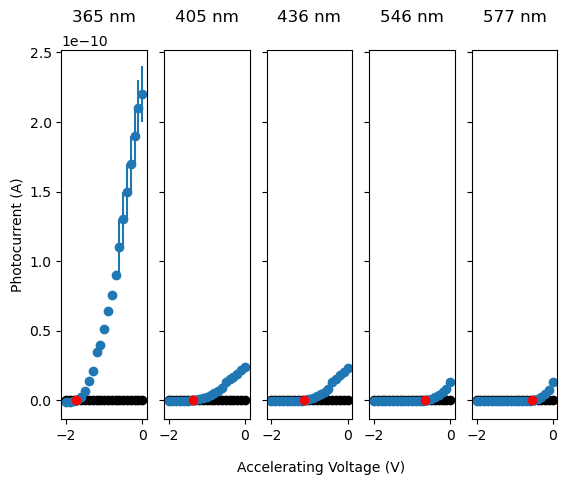

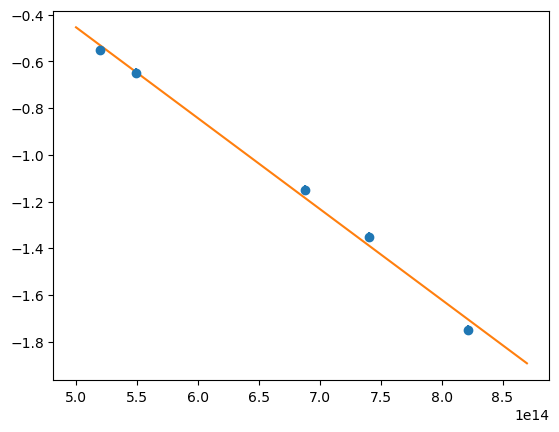

In [101]:
import DataAnalysisTools as dat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def dataIntersectionPoint(x, y1, y2, x_unc = 0, y1_unc = 0, y2_unc = 0):
    idx = np.argwhere(np.diff(np.sign(y1 - y2)) != 0).flatten()
    xInt = []
    x_uncInt = []
    yInt = []
    y_uncInt = []
    for i in idx:
        xInt.append((x[i] + x[i+1])/2)
        x_uncInt.append((x_unc[i] + x_unc[i+1])/2)
        yInt.append((y1[i] + y1[i+1] + y2[i] + y2[i+1])/4)
        y_uncInt.append((y1_unc[i] + y1_unc[i+1] + y1_unc[i] + y1_unc[i+1])/4)
    return xInt, yInt, x_uncInt, y_uncInt

data3650 = pd.read_csv(r"Re_ Experiment 3 Data\3650AngstromFilterData.csv")
data4047 = pd.read_csv(r"Re_ Experiment 3 Data\4047AngstromFilterData.csv")
data4358 = pd.read_csv(r"Re_ Experiment 3 Data\4358AngstromFilterData.csv")
data5461 = pd.read_csv(r"Re_ Experiment 3 Data\5461AngstromFilterData.csv")
data5770 = pd.read_csv(r"Re_ Experiment 3 Data\5770AngstromFilterData.csv")
dataDark = pd.read_csv(r"Re_ Experiment 3 Data\DarkCurrentData.csv")
data = [data3650, data4047, data4358, data5461, data5770, dataDark]

wavelength = [365, 405, 436, 546, 577]
c = 2.998e8
e = 1.6021766e-19
me = 9.109387e-31
freq = np.divide(c, np.array(wavelength)*10.0**-9)

darkCurrent = (data[5].I_meter * (10.0**data[5].Range_Exponent)/100)
dark_unc = 0.02 * (10.0**data[5].Range_Exponent)
x = data[5].Voltage
x_unc = [0.02 for i in range(len(data[5]))]

fig1, axes = plt.subplots(1, 5, sharey = True)
axes[0].set_ylabel("Photocurrent (A)")
fig1.text(0.4, 0, "Accelerating Voltage (V)")
stoppingPotential = []
stoppingPotential_unc = []
for i in range(len(data)-1):
    y_unc = 0.02 * (10.0**data[i].Range_Exponent)
    y = (data[i].I_meter * (10.0**data[i].Range_Exponent)/100) 
    axes[i].set_title(f"{wavelength[i]} nm", pad=20)
    axes[i].errorbar(x, darkCurrent, fmt='o', xerr=x_unc, yerr=dark_unc, c = 'k')
    axes[i].errorbar(x, y, fmt = 'o', xerr = x_unc, yerr = y_unc)
    xInt , yInt, x_uncInt, y_uncInt = dat.dataIntersectionPoint(x, y, darkCurrent, x_unc=x_unc, y1_unc=y_unc, y2_unc=dark_unc)
    intersections = list(zip(xInt, yInt))
    stoppingPotential.extend(xInt)
    stoppingPotential_unc.extend(x_uncInt)
    for j in intersections:
        axes[i].errorbar(j[0], j[1], fmt = 'o', c = 'r', xerr = x_uncInt, yerr = y_uncInt)
fig2 = plt.figure()
ax2 = fig2.add_subplot()
ax2.errorbar(freq, stoppingPotential, yerr=x_uncInt, fmt ='o')
m, b, dm, db = dat.lineFitWt(freq, stoppingPotential, stoppingPotential_unc)
x = np.linspace(5e14, 8.7e14, 100000)
y = m*x + b
ax2.plot(x, y)
print(f"h = ({-m*e} ± {dm*e}) J·s")
dict = {"Wavelength (nm)":wavelength, "Stopping Potential (V)":stoppingPotential}
df = pd.DataFrame(dict)
display(df)
h = 6.62607015e-34
delta, sig, agree = dat.discrepancy(-m*e, dm*e, h, 0)
if agree:
    print(f'The calculated value, {-m*e:.4} J·s, agrees with the accepted value, {h:.4} J·s. They differ by {delta:.3} J·s and the total uncertainty is {sig:.3} J·s.')
else:
    print(f'The calculated value, {-m*e:.4}, does not agree with the accepted value, {h:.4}. They differ by {delta:.3} and the total uncertainty is {sig:.3}.')
print(f'The relative error is {dat.relativeError(-m*e, h) * 100:.3}%.')
print(f'The work function of the devices cathode is ({b*e:.3} ± {db*e:.3}) J')
vMax = np.sqrt(2*np.abs(np.array(stoppingPotential))/5.11e5)*c
dict = {"Wavelength": wavelength, "Maximum Velocity (m/s)": vMax}
df = pd.DataFrame(dict)
df.round(1)